# Realizēt filtrēšanu ar Furjē transformācijas palīdzību

## Nolasām sakotnējo atteli

In [19]:
import numpy as np                          # Numerical Python 
import matplotlib.pyplot as plt             # Python plotting
from PIL import Image                       # Python Imaging Library
from numpy.fft import fft2, fftshift, ifft2 # Python DFT

%matplotlib inline

Text(0.5, 1.0, 'Original image')

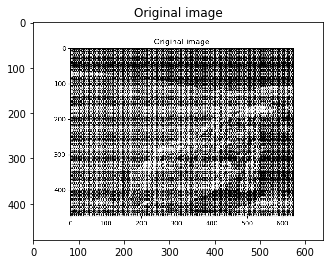

In [25]:
img = plt.imread('./assets/moonlanding.png').astype(float)

plt.figure()
plt.imshow(img, plt.cm.gray)
plt.title('Original image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Fourier transform')

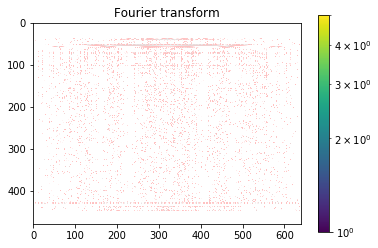

In [27]:
from scipy import fftpack
im_fft = fftpack.fft2(img)

# Show the results

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Filtered Spectrum')

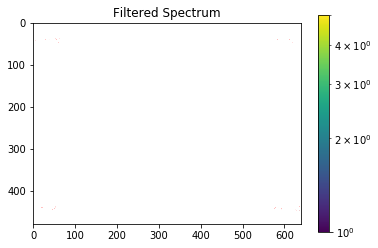

In [29]:
# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.1

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c, _ = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

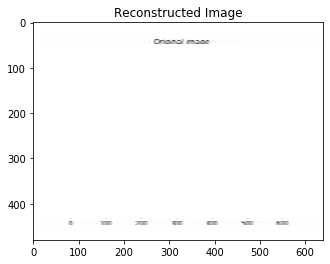

In [30]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

In [35]:
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [36]:
def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N / 2] * X_odd,
                               X_even + factor[N / 2:] * X_odd])

In [40]:
def FFT2D(x):    
    for i in range(np.size(x)):
        x[i] = FFT(x[i])
    return x

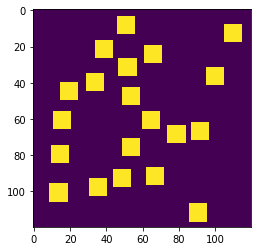

TypeError: slice indices must be integers or None or have an __index__ method

In [44]:
import numpy as np
import pylab

# image size, square side length, number of squares
ncols, nrows = 120, 120
sq_size, nsq = 10, 20

# The image array (0=background, 1=square) and boolean array of allowed places
# to add a square so that it doesn't touch another or the image sides
image = np.zeros((nrows, ncols))
sq_locs = np.zeros((nrows, ncols), dtype=bool)
sq_locs[1:-sq_size-1:,1:-sq_size-1] = True

def place_square():
    """ Place a square at random on the image and update sq_locs. """
    # valid_locs is an array of the indices of True entries in sq_locs
    valid_locs = np.transpose(np.nonzero(sq_locs))
    # pick one such entry at random, and add the square so its top left
    # corner is there; then update sq_locs
    i, j = valid_locs[np.random.randint(len(valid_locs))]
    image[i:i+sq_size, j:j+sq_size] = 1
    imin, jmin = max(0,i-sq_size-1), max(0, j-sq_size-1)
    sq_locs[imin:i+sq_size+1, jmin:j+sq_size+1] = False

# Add the required number of squares to the image
for i in range(nsq):
    place_square()
pylab.imshow(image)
pylab.show()

# Take the 2-dimensional DFT and centre the frequencies
ftimage = FFT(image)
ftimage = np.fft.fftshift(ftimage)
pylab.imshow(np.abs(ftimage))
pylab.show()


# Build and apply a Gaussian filter.
sigmax, sigmay = 10, 10
cy, cx = nrows/2, ncols/2
x = np.linspace(0, nrows, nrows)
y = np.linspace(0, ncols, ncols)
X, Y = np.meshgrid(x, y)
gmask = np.exp(-(((X-cx)/sigmax)**2 + ((Y-cy)/sigmay)**2))

ftimagep = ftimage * gmask
pylab.imshow(np.abs(ftimagep))
pylab.show()

# Finally, take the inverse transform and show the blurred image
imagep = np.fft.ifft2(ftimagep)
pylab.imshow(np.abs(imagep))
pylab.show()